In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../Style.mplstyle')
import pandas as pd
import os
import sys
import scipy
import matplotlib.dates as mdates
from datetime import datetime
sys.path.append('..')
from read_data_functions import *
from plot_functions import *
from calculations import *

In [2]:
parent_path = '../../../../'
path = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/'

# Screening
Screening_LCS = read_LCS_data(path + 'pilot kbh hovedbanegaard and noerregade/rawdata/particle/LCS/', parent_path, 'timestamp', 0, False, False)

# Brake wear data
Lund_LCS = read_LCS_data(path + 'Lund/LCS_vores/', parent_path, 'timestamp', 0, True, False)
Lund_OPS = read_OPS(path + 'Lund/', parent_path, 0)

# Field data
Field_LCS1 = read_LCS_data(path + 'cph central and nørreport measurements/Station 1/', parent_path, 'timestamp', 0, False, False)
Field_OPS1 = read_OPS(path + 'cph central and nørreport measurements/Station 1/OPS/', parent_path, 0)
Field_LCS2 = read_LCS_data(path + 'cph central and nørreport measurements/Station 2/', parent_path, 'timestamp', 0, False, False)
Field_OPS2 = read_OPS(path + 'cph central and nørreport measurements/Station 2/OPS/', parent_path, -1)

# Flip selected dataframes and change dataframe concentration keys
old_keys_DSB = ['SPS30_PN0.5', 'SPS30_PN1', 'SPS30_PN2.5', 'SPS30_PN4', 'SPS30_PN10']
old_keys_Lund_flip = ['PM5000S_2_PN0.3', 'PM5000S_2_PN0.5', 'PM5000S_2_PN1', 'PM5000S_2_PN2.5', 'PM5000S_2_PN5', 'PM5000S_2_PN10']
old_keys_Lund = ['PN0.5, #/cm3', 'PN1, #/cm3', 'PN2.5, #/cm3', 'PN4, #/cm3', 'PN10, #/cm3']

Screening_keys = ['2024-09-17 DG-0001A', '2024-09-19 DG-0001A', '2024-09-17 LCS0076', 
                  '2024-09-19 LCS0076', '2024-09-17 LCS0104', '2024-09-19 LCS0104']
Lund_keys = ['2024-10-15 DG-0049', '2024-10-16 DG-0049', '2024-10-17 DG-0049', '2024-10-15 DG-0051', '2024-10-16 DG-0051', 
             '2024-10-17 DG-0051', '2024-10-15 LCS109', '2024-10-16 LCS109', '2024-10-17 LCS109', '2024-10-15 DG-0072', 
             '2024-10-16 DG-0072', '2024-10-17 DG-0072', '2024-10-15 DG-0077', '2024-10-16 DG-0077', '2024-10-17 DG-0077']
Field1_keys = ['2024-12-09 DG-0158', '2024-12-10 DG-0158', '2024-12-11 DG-0158', '2024-12-12 DG-0158', 
               '2024-12-13 DG-0158', '2024-12-16 DG-0158', '2024-12-17 DG-0158']
Field2_keys = ['2024-12-09 DG-0159', '2024-12-10 DG-0159', '2024-12-11 DG-0159', '2024-12-12 DG-0159', 
               '2024-12-13 DG-0159', '2024-12-16 DG-0159', '2024-12-17 DG-0159']

Screening_flip = [False, False, False, False, False, False]
Lund_flip = [True, True, True, True, True, True, True, True, True, False, False, False, False, False, False]
Field_flip = [False, False, False, False, False, False, False]

Screening_LCS = LCS_bins(Screening_LCS, Screening_keys, None, Screening_flip, old_keys_DSB)
Lund_LCS = LCS_bins(Lund_LCS, Lund_keys, old_keys_Lund_flip, Lund_flip, old_keys_Lund)
Field_LCS1 = LCS_bins(Field_LCS1, Field1_keys, None, Field_flip, old_keys_DSB)
Field_LCS2 = LCS_bins(Field_LCS2, Field2_keys, None, Field_flip, old_keys_DSB)

# Merge dictionaries with data from train stations
DSB_LCS = merge_dicts(Screening_LCS, Field_LCS1, Field_LCS2)
DSB_OPS = merge_dicts(Field_OPS1, Field_OPS2)

c:\Users\B363580\Documents\GitHub\Master-thesis\calibration\..\read_data_functions.py:197: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df[time_label]).dt.date


In [3]:
print(DSB_LCS['2024-09-17 LCS0076'].keys())
print(Lund_LCS['2024-10-15 DG-0077'].keys())

Index(['Time', 'PN0.5', 'PN<1', 'PN<2.5', 'PN<5', 'PN<10'], dtype='object')
Index(['Time', 'PN0.5', 'PN<1', 'PN<2.5', 'PN<5', 'PN<10'], dtype='object')


In [4]:
DSB_keys_cal = ['2024-09-17 LCS0076', '2024-09-17 LCS0104', 
                '2024-12-09 DG-0158', '2024-12-09 DG-0159',]
Lund_keys_cal = ['2024-10-15 DG-0049', '2024-10-15 DG-0051', '2024-10-15 LCS109', 
                 '2024-10-15 DG-0072', '2024-10-15 DG-0077']

In [5]:
Lund_idx = [[90, 165], [88, 163], [183, 258], [92, 167], [91, 166], [0, -1]] # 2 min running mean
Lund_cal_df = pd.DataFrame()

for idx, key in zip(Lund_idx[:5], Lund_keys_cal):
    print(key)
    df = Lund_LCS[key]
    smoothed_df = running_mean(df, 'PN<2.5', 'PN<2.5', 'Time', '2T', 2, None)
    smoothed_df = smoothed_df.dropna()
    print(smoothed_df.index[idx[0]], smoothed_df.index[idx[1]])
    print(len(smoothed_df.index[idx[0]:idx[1]]))
    Lund_cal_df['Time ' + key.split(' ')[1]] = np.array(smoothed_df.index[idx[0]:idx[1]])
    Lund_cal_df['PN<2.5 ' + key.split(' ')[1]] = np.array(smoothed_df['PN<2.5'][idx[0]:idx[1]])

smoothed_df = running_mean(Lund_OPS['Initial'], 'PN<2.5', 'PN2.5', 'Time', '2T', 2, None)
print('OPS')
print(smoothed_df.index[Lund_idx[-1][0]], smoothed_df.index[Lund_idx[-1][1]])
print(len(smoothed_df.index[Lund_idx[-1][0]:Lund_idx[-1][1]]))
Lund_cal_df['Time OPS'] = np.array(smoothed_df.index[Lund_idx[-1][0]:Lund_idx[-1][1]])
Lund_cal_df['PN<2.5 OPS'] = np.array(smoothed_df['PN<2.5'][Lund_idx[-1][0]:Lund_idx[-1][1]])

2024-10-15 DG-0049
2024-10-15 14:00:00 2024-10-15 16:30:00
75
2024-10-15 DG-0051
2024-10-15 14:00:00 2024-10-15 16:30:00
75
2024-10-15 LCS109
2024-10-15 14:00:00 2024-10-15 16:30:00
75
2024-10-15 DG-0072
2024-10-15 14:00:00 2024-10-15 16:30:00
75
2024-10-15 DG-0077
2024-10-15 14:00:00 2024-10-15 16:36:00
75
OPS
2024-10-15 14:04:00 2024-10-15 16:34:00
75


In [6]:
DSB_idx = [[405,530], [405,530], [370,495], [94,219], [42,167], [44,169]] # 2 min running mean
# DSB_idx = [[250,360], [250,360], [220,330], [36,146], [2,112], [3,113]] # 3 min running mean
DSB_cal_df = pd.DataFrame()

for idx, key in zip(DSB_idx[:4], DSB_keys_cal):
    print(key)
    df = DSB_LCS[key]
    smoothed_df = running_mean(df, 'PN<2.5', 'PN<2.5', 'Time', '2T', 2, None)
    print(smoothed_df.index[idx[0]], smoothed_df.index[idx[1]])
    print(len(smoothed_df.index[idx[0]:idx[1]]))
    DSB_cal_df['Time ' + key.split(' ')[1]] = np.array(smoothed_df.index[idx[0]:idx[1]])
    DSB_cal_df['PN<2.5 ' + key.split(' ')[1]] = np.array(smoothed_df['PN<2.5'][idx[0]:idx[1]])

for idx, key in zip(DSB_idx[4:], ['OPS1-CPH-d1', 'OPS2-CPH-d1']):
    print(key)
    df = DSB_OPS[key]
    smoothed_df = running_mean(df, 'PN<2.5', 'PN2.5', 'Time', '2T', 2, None)
    print(smoothed_df.index[idx[0]], smoothed_df.index[idx[1]])
    print(len(smoothed_df.index[idx[0]:idx[1]]))
    DSB_cal_df['Time ' + key.split('-')[0]] = np.array(smoothed_df.index[idx[0]:idx[1]])
    DSB_cal_df['PN<2.5 ' + key.split('-')[0]] = np.array(smoothed_df['PN<2.5'][idx[0]:idx[1]])

2024-09-17 LCS0076
2024-09-17 13:30:00 2024-09-17 17:40:00
125
2024-09-17 LCS0104
2024-09-17 13:30:00 2024-09-17 17:40:00
125
2024-12-09 DG-0158
2024-12-09 12:20:00 2024-12-09 16:30:00
125
2024-12-09 DG-0159
2024-12-09 12:20:00 2024-12-09 16:30:00
125
OPS1-CPH-d1
2024-12-09 12:20:00 2024-12-09 16:30:00
125
OPS2-CPH-d1
2024-12-09 12:20:00 2024-12-09 16:30:00
125


PN<2.5 LCS0104 vs PN<2.5 LCS0076:
f(x) = 1.2078918324986259x, R2 = 0.8666484941296498
PN<2.5 DG-0158 vs PN<2.5 LCS0076:
f(x) = 0.9791773373990194x, R2 = 0.9454184657158825
PN<2.5 DG-0158 vs PN<2.5 LCS0104:
f(x) = 0.8023705155606912x, R2 = 0.739215783413439
PN<2.5 DG-0159 vs PN<2.5 LCS0076:
f(x) = 1.9650108190299784x, R2 = 0.9877779494406159
PN<2.5 DG-0159 vs PN<2.5 LCS0104:
f(x) = 1.612218298728207x, R2 = 0.8433508213175999
PN<2.5 DG-0159 vs PN<2.5 DG-0158:
f(x) = 1.9430927531268152x, R2 = 0.9663845482796884
PN<2.5 OPS1 vs PN<2.5 LCS0076:
f(x) = 1.4041378189846971x, R2 = 0.9853904037064884
PN<2.5 OPS1 vs PN<2.5 LCS0104:
f(x) = 1.151852353112757x, R2 = 0.8488267773818924
PN<2.5 OPS1 vs PN<2.5 DG-0158:
f(x) = 1.3843616492869972x, R2 = 0.9686248280665878
PN<2.5 OPS1 vs PN<2.5 DG-0159:
f(x) = 0.7130952993309128x, R2 = 0.9955725591006677
PN<2.5 OPS2 vs PN<2.5 LCS0076:
f(x) = 1.1010710145142435x, R2 = 0.9541630384048052
PN<2.5 OPS2 vs PN<2.5 LCS0104:
f(x) = 0.9028691278805646x, R2 = 0.764285

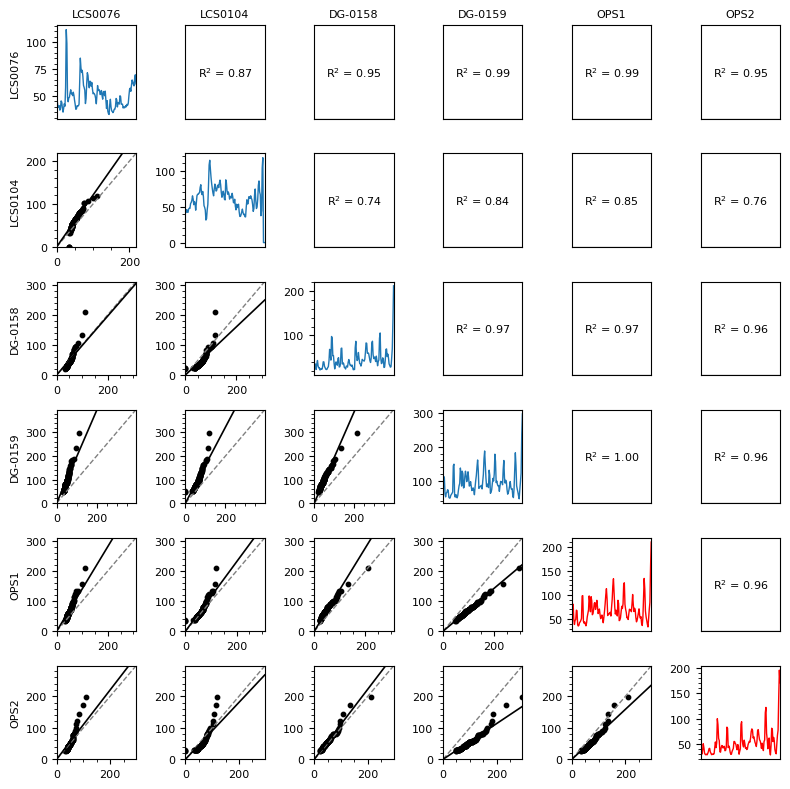

In [7]:
DSB_fig, a_DSB, R2_DSB = LCS_calibration_plot(7, (8, 8), DSB_cal_df, linear_forced_zero)
DSB_fig.tight_layout()
DSB_fig.savefig('DSB_LCS_uncorrected.png', dpi = 600)

PN<2.5 DG-0051 vs PN<2.5 DG-0049:
f(x) = 1.1183732932687767x, R2 = 0.9997067453052841
PN<2.5 LCS109 vs PN<2.5 DG-0049:
f(x) = 1.1483174725042589x, R2 = 0.9963110250380146
PN<2.5 LCS109 vs PN<2.5 DG-0051:
f(x) = 1.0270061194723124x, R2 = 0.9965286596467561
PN<2.5 DG-0072 vs PN<2.5 DG-0049:
f(x) = 0.678738799046879x, R2 = 0.9986681952671725
PN<2.5 DG-0072 vs PN<2.5 DG-0051:
f(x) = 0.6067867317839071x, R2 = 0.9981036870542602
PN<2.5 DG-0072 vs PN<2.5 LCS109:
f(x) = 0.5843343093783072x, R2 = 0.9941492126483231
PN<2.5 DG-0077 vs PN<2.5 DG-0049:
f(x) = 0.6698874134631672x, R2 = 0.9921183728746747
PN<2.5 DG-0077 vs PN<2.5 DG-0051:
f(x) = 0.5988135993143558x, R2 = 0.9913088774645831
PN<2.5 DG-0077 vs PN<2.5 LCS109:
f(x) = 0.5754713649416123x, R2 = 0.9855922762784534
PN<2.5 DG-0077 vs PN<2.5 DG-0072:
f(x) = 0.9867901169047225x, R2 = 0.9929548151113116
PN<2.5 OPS vs PN<2.5 DG-0049:
f(x) = 0.759417216305273x, R2 = 0.9990076973169221
PN<2.5 OPS vs PN<2.5 DG-0051:
f(x) = 0.6789863655748987x, R2 = 0

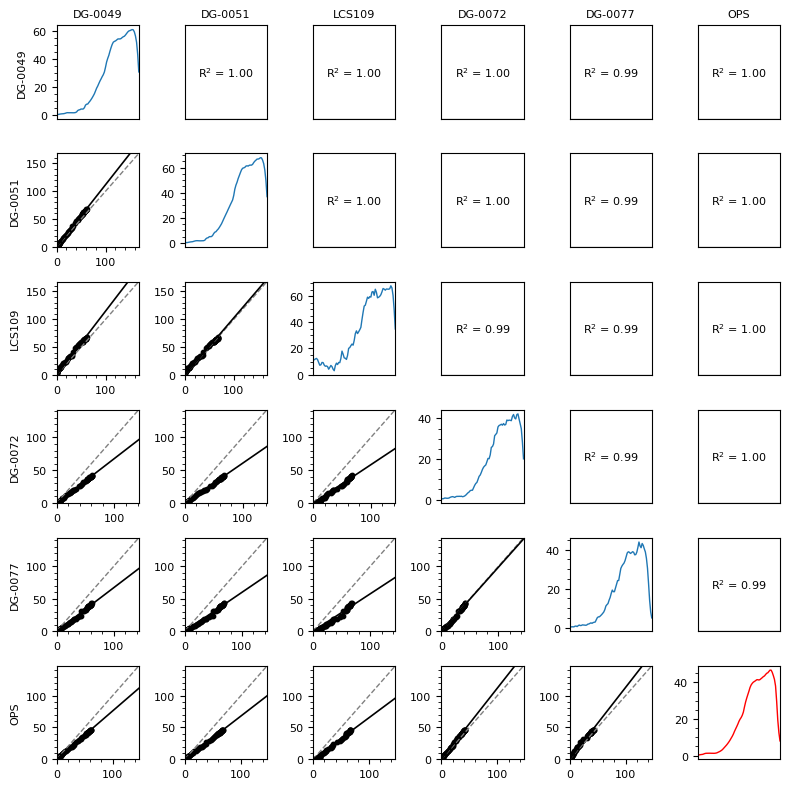

In [8]:
Lund_fig, a_Lund, R2_Lund = LCS_calibration_plot(7, (8, 8), Lund_cal_df, linear_forced_zero)
Lund_fig.tight_layout()
Lund_fig.savefig('Lund_LCS_uncorrected.png', dpi = 600)

In [9]:
idxs = [0, 0, 1, 1]
for idx, key in zip(idxs, Screening_keys[2:]):
    device_id = key.split(' ')[1]
    screening_path = path + 'pilot kbh hovedbanegaard and noerregade/rawdata/particle/Korrigeret low cost sensor/'
    corrected = get_corrected(screening_path, DSB_LCS, device_id, a_DSB[idx], 'LCS')
    
idxs = [3]*7
for idx, key in zip(idxs, Field2_keys):
    device_id = key.split(' ')[1]
    field_path = path + 'cph central and nørreport measurements/Korrigeret low cost sensor/'

    corrected = get_corrected(field_path, DSB_LCS, device_id, a_DSB[idx], 'LCS')

idxs = [6]*7
for idx, key in zip(idxs, Field1_keys):
    device_id = key.split(' ')[1]
    field_path = path + 'cph central and nørreport measurements/Korrigeret low cost sensor/'

    corrected = get_corrected(field_path, DSB_LCS, device_id, a_DSB[idx], 'LCS')

for i, key in enumerate(Lund_keys[::3]):
    device_id = key.split(' ')[1]
    Lund_path = path + 'Lund/Korrigeret low cost sensor/'

    corrected = get_corrected(Lund_path, Lund_LCS, device_id, a_Lund[i], 'LCS')
